# PiD Machine learning project

The chosen dataset https://www.kaggle.com/code/marianna13/starter-particle-identification-from-94dec2e4-9/input?select=pid-5M.csv is a GEANT4 simulated dataset of electron proton inelastic scattering containing data for protons, positrons, kaons and pions, let's have a look.

In [746]:
import sys, os
import pandas as pd
import numpy as np
import warnings
import gzip, io, requests
import time

nRowsRead = 1000000
filename="datasets/pid-5M.csv"
complete_dataset=pd.read_csv(filename, nrows = nRowsRead)


print("The dataset contains:  " + str(complete_dataset.shape[0]) + " rows and " + str(complete_dataset.shape[1]) + " columns" )
complete_dataset.head()

The dataset contains:  1000000 rows and 7 columns


,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


The first column is the label which we want to predict using our models. We have:
- Positron: -11
- Pion: 211
- Kaon: 321
- Proton: 2212

The rest of the dataset resembles data coming from a particle detector, so we have:
- The momentum P (GeV/c), 
- The angle with respect to the beam direction theta (radiant), 
- The factor \beta, 
- The number of photoelectron emitted,
- What I think is the energy deposited in the inner and outer region of the detector.

I'm going to Ignore the last three columns, beta and the momentum should be enough for PiD

In [747]:
nFeatures = 3
nLabels = 4
complete_dataset.drop(complete_dataset.columns[-nFeatures:], axis=1, inplace=True)
print("The dataset now contains:  " + str(complete_dataset.shape[0]) + " rows and " + str(complete_dataset.shape[1]) + " columns" )
complete_dataset.head()


The dataset now contains:  1000000 rows and 4 columns


,id,p,theta,beta
0,211,0.780041,1.081480,0.989962
1,211,0.260929,0.778892,0.902450
2,2212,0.773022,0.185953,0.642428
3,211,0.476997,0.445561,0.951471
4,2212,2.123290,0.337332,0.908652


Now we are interested to see how many particles of each kind are in the dataset and make sure to divide out train and test set accordingly.

In [748]:
N_Test = 100000
N_Train = nRowsRead - N_Test

train_df = complete_dataset.iloc[:N_Train]

# Create Test dataset with the remaining rows
test_df = complete_dataset.iloc[N_Train:]

# Optionally, you can reset the index for both datasets
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print("The train dataset contains:  " + str(train_df.shape[0]) + " rows and " + str(train_df.shape[1]) + " columns" )
train_df.head()

#print("The test dataset contains:  " + str(test_df.shape[0]) + " rows and " + str(test_df.shape[1]) + " columns" )
#test_df.head()


The train dataset contains:  900000 rows and 4 columns


,id,p,theta,beta
0,211,0.780041,1.081480,0.989962
1,211,0.260929,0.778892,0.902450
2,2212,0.773022,0.185953,0.642428
3,211,0.476997,0.445561,0.951471
4,2212,2.123290,0.337332,0.908652


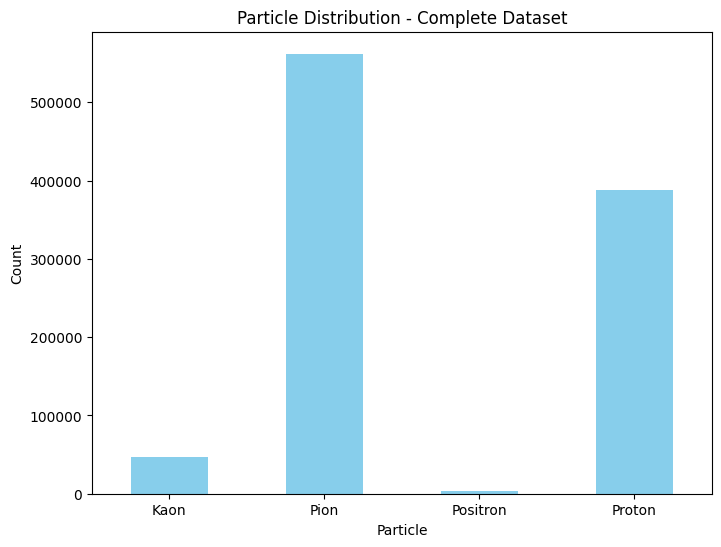

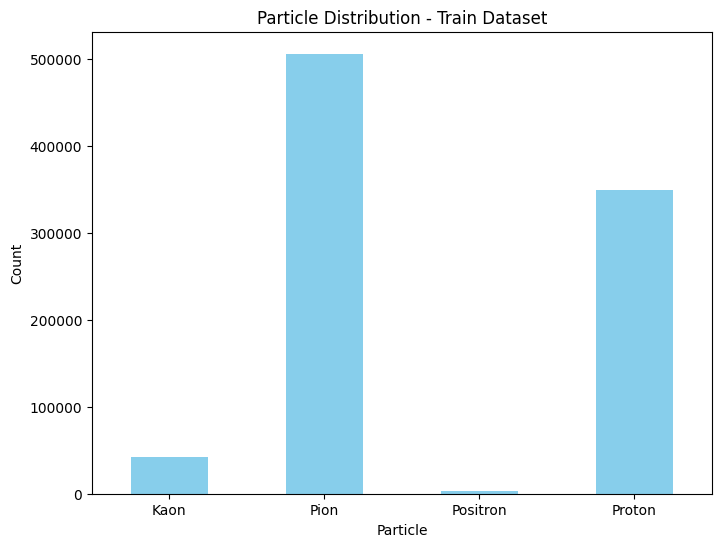

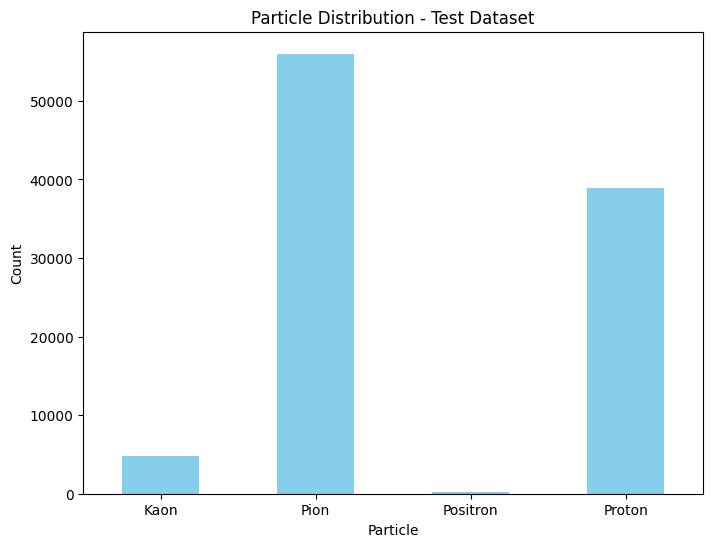

In [749]:
import matplotlib.pyplot as plt

# Define particle ID labels
particle_labels = {
    -11: 'Positron',
    211: 'Pion',
    321: 'Kaon',
    2212: 'Proton'
}

# Function to plot histogram
def plot_histogram(data, title):
    plt.figure(figsize=(8, 6))
    data.value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Particle')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

# Plot histogram for complete dataset
plot_histogram(complete_dataset['id'].map(particle_labels), 'Particle Distribution - Complete Dataset')

# Plot histogram for train dataset
plot_histogram(train_df['id'].map(particle_labels), 'Particle Distribution - Train Dataset')

# Plot histogram for test dataset
plot_histogram(test_df['id'].map(particle_labels), 'Particle Distribution - Test Dataset')

It's a very imbalaced dataset.

Let's fix it.

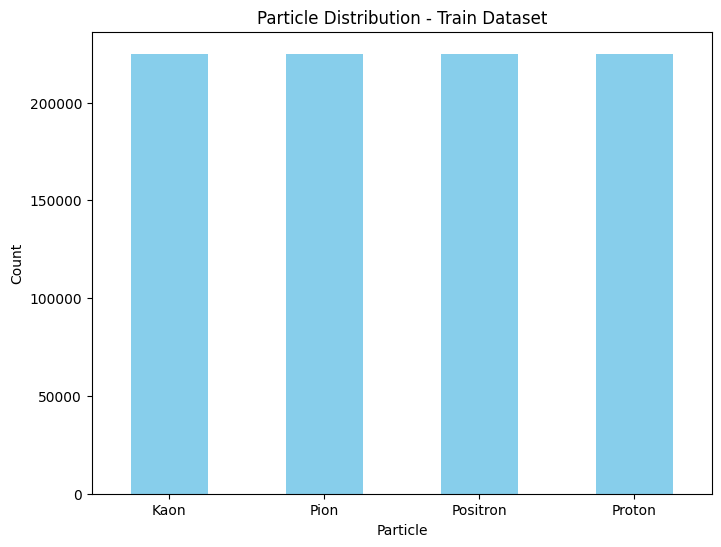

In [750]:
from sklearn.utils import resample

# First divide in classes
kaons_df = train_df[train_df['id'] == 321]
pions_df = train_df[train_df['id'] == 211]
positrons_df = train_df[train_df['id'] == -11]
protons_df = train_df[train_df['id'] == 2212]

# Now try to oversample Kaons and Positrons, while undesampling Pions and Protons
sample_target = round(N_Train/4)
kaons_df = kaons_df.sample(sample_target, replace=True)
pions_df = pions_df.sample(sample_target)
positrons_df = positrons_df.sample(sample_target, replace=True)
protons_df = protons_df.sample(sample_target)

train_df = pd.concat([kaons_df, pions_df, positrons_df, protons_df], axis=0)
train_df.head()
plot_histogram(train_df['id'].map(particle_labels), 'Particle Distribution - Train Dataset')



Now the dataset looks well balanced!

Finally, it is better to shuffle the dataframe as this avoids introducing any bias.

In [751]:
train_df = train_df.sample(frac=1, random_state=42)
train_df.head()

,id,p,theta,beta
74196,-11,2.083770,0.303325,0.993022
831853,-11,1.486530,0.172335,0.992732
497020,-11,0.794232,0.285853,0.995910
725612,321,1.557180,0.214095,0.933537
708721,2212,0.829480,0.504169,0.650132


Finally we store the features and the labels in different arrays. It is also useful to make a dictionary to easily change between particle IDs and integers if needed as index.

In [752]:
features_array = train_df.iloc[:, -3:].values
IDs_array = train_df.iloc[:,0].values
features_and_IDs = train_df.iloc[:, -4:].values
#print(features_and_IDs)

test_features_array = test_df.iloc[:, -3:].values
test_IDs_array = test_df.iloc[:,0].values

particleIDs_index = {
    # This choice follows the plots above
    -11: 2,   # Positron
    211: 1,   # Pion
    321: 0,   # Kaon
    2212: 3   # Proton
}

# Useful for later
IDs_indeces = (train_df["id"].map(particleIDs_index)).values
num_samples = features_array.shape[0]

#print(IDs_indeces)
#print(len(IDs_indeces))
#print(len(IDs_indeces.dropna().index))


# First approach: Linear Model

Here we follow the same steps saw during lesson.

Let's start by defining the linear model as follows:


 ${\rm z}_j = X_{i} W_{ij}+b_{j}$

 where, $i=1,2,3$ (i.e. the three features), $j=1,2,3,4$ (Kaon, Pion, Positron, Proton). The probability of this score is given using the sigmoid function:

   $\sigma(z_j) = \frac{\exp(-z_j)}{\sum_k \exp(-z_k)}$
  
repeated indices are understood to be summed over. By definition,

  $\sum_j \sigma(z_j) = 1$
  
so $P(X) = \sigma(z(X))$ outputs 4 values (4 particles) between 0 and 1 that sum to 1.

The final prediction of the model would be the most likely of the possible particle:

${\rm Particle}_{\rm pred} = {\rm argmax}(z(X))$

which is its particle ID:
- Positron: -11
- Pion: 211
- Kaon: 321
- Proton: 2212

Now it's time to initialize and train the model


Let's first start with gradient descent method

In [753]:
from IPython.display import display, clear_output
%matplotlib inline
# initialize parameters randomly
W = 0.01 * np.random.randn(nFeatures,nLabels)
b = np.zeros((1,nLabels))


# gradient descent loop
num_samples = features_array.shape[0]

# For SGD
SGD = True

# Plotting losses
show_plot = False
losses = []

if(SGD):
    iterations = 1
    print_freq = 10
    
    # some hyperparameters
    step_size = 1.2
    reg = 1e-3 # regularization strength
    batch_size = 32

    for i in range(iterations):

        # This selects "bunch_size" indices ranging from [0, num_samples) whitout replacing
        batch_indices = np.random.choice(num_samples, batch_size, replace=False)



        # Extract the corresponding labels and features
        batch_features = features_array[batch_indices]
        batch_labels = IDs_indeces[batch_indices]

        # evaluate class scores, [N x n_colours]
        scores = np.dot(batch_features, W) + b

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x n_colours]

        # compute the loss: average cross-entropy loss and regularization
        logprobs = -np.log(probs[range(batch_size),batch_labels])
        data_loss = np.sum(logprobs)/batch_size
        reg_loss = 0.5*reg*np.sum(W*W)
        
        # Early stopping is harder for SGD
        #if(i !=0 ):
        #    if(loss < data_loss + reg_loss):
        #        break
        loss = data_loss + reg_loss



        if i % (print_freq) == 0:
            clear_output(wait=True)
            losses.append(loss)
            cumulative_loss = np.cumsum(losses)
            
            # Calculate the average loss at each iteration
            avg_loss = cumulative_loss / np.arange(print_freq, i+print_freq +1, print_freq)
            print("iteration %d: loss %f, avg loss %g" % (i, loss, avg_loss[-1]))

            if(show_plot):
                # Plot the losses
                plt.plot(np.arange(print_freq, i+print_freq + 1, print_freq), avg_loss, color='blue')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Average Loss vs Iteration (SDG)')
                plt.grid(True)
                display(plt.gcf())  # Display the current figure
                #clear_output(wait=True)  # Clear the output for the next iteration
                #plt.pause(0.01)  # Pause for a short time to update the plot
                plt.clf()  # Clear the current figure for the next iteration
                plt.show()

        # compute the gradient on scores
        dscores = probs
        dscores[range(batch_size),batch_labels] -= 1
        dscores /= batch_size

        # backpropate the gradient to the parameters (W,b)
        dW = np.dot(batch_features.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)

        dW += reg*W # regularization gradient

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db



### NON SDG
else:

    # some hyperparameters
    step_size = 1
    reg = 1e-3 # regularization strength
    iterations = 1000000
    print_freq = 10
    for i in range(1000):

        # evaluate class scores, [N x n_colours]
        scores = np.dot(features_array, W) + b

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x n_colours]

        # compute the loss: average cross-entropy loss and regularization
        logprobs = -np.log(probs[range(num_samples),IDs_indeces])
        data_loss = np.sum(logprobs)/num_samples
        reg_loss = 0.5*reg*np.sum(W*W)
        
        # Implementing early stopping
        if(i !=0 ):
            if(loss < data_loss + reg_loss):
                break
        loss = data_loss + reg_loss



        if i % print_freq == 0:
            clear_output(wait=True)
            print("iteration %d: loss %f" % (i, loss))

            if(show_plot):
                losses.append(loss)

                plt.clf()  # Clear the current figure for the next iteration
                # Plot the losses
                plt.plot(np.arange(print_freq, i+print_freq+1, print_freq), losses, color='blue')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Loss vs Iteration')
                plt.grid(True)
                #display(plt.gcf())  # Display the current figure
                #clear_output(wait=True)  # Clear the output for the next iteration
                #plt.pause(0.01)  # Pause for a short time to update the plot
                plt.show()


        # compute the gradient on scores
        dscores = probs
        dscores[range(num_samples),IDs_indeces] -= 1
        dscores /= num_samples

        # backpropate the gradient to the parameters (W,b)
        dW = np.dot(features_array.T, dscores)
        db = np.sum(dscores, axis=0, keepdims=True)

        dW += reg*W # regularization gradient

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db




iteration 0: loss 1.382724, avg loss 0.138272


In [754]:
scores = np.dot(features_array, W) + b
predicted_col = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_col == IDs_indeces)))

# Note: 0.68 accuracy after 10 000 iterations and 1h of training, step size = 1
#print(W)

training accuracy: 0.25


The training is done, let's now check the performances

In [755]:
random_particle = np.random.randint(0, len(test_features_array + 1))
print("Extracted row = ", random_particle)
scores = np.dot(test_features_array[random_particle], W) + b
print("Scores:")
print("- Kaon:     ", scores[0][0])
print("- Pion:     ", scores[0][1])
print("- Positron: ", scores[0][2])
print("- Proton:   ", scores[0][3])
print("Extracted test particle: ",particle_labels[test_IDs_array[random_particle]])
index = np.argmax(scores)
particle_id = next(key for key, value in particleIDs_index.items() if value == index)
print("Predicted Particle: ", particle_labels[particle_id])


Extracted row =  34494
Scores:
- Kaon:      0.05793652483412405
- Pion:      -0.49312858823160083
- Positron:  -0.010038666544869998
- Proton:    0.4844824672980053
Extracted test particle:  Proton
Predicted Particle:  Proton


# Second Approach: Non linear model using Neural Network.

In [768]:
%matplotlib inline


h = 100 # size of hidden layer
W = 0.01 * np.random.randn(nFeatures,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,nLabels)
b2 = np.zeros((1,nLabels))


num_samples = features_array.shape[0]


# For SGD
SGD = False

# Plotting losses
show_plot = True
losses = []


if(SGD):

    iterations = 1000000
    print_freq = 10

    # some hyperparameters for the gradient descent
    step_size = 1.25
    reg = 1e-3 # regularization strength
    batch_size = 32

    for i in range(iterations):

        # This selects "bunch_size" indices ranging from [0, num_samples) whitout replacing
        batch_indices = np.random.choice(num_samples, batch_size, replace=False)



        # Extract the corresponding labels and features
        batch_features = features_array[batch_indices]
        batch_labels = IDs_indeces[batch_indices]


        # evaluate class scores, [N x n_colours]
        hidden_layer = np.maximum(0, np.dot(batch_features, W) + b) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        correct_logprobs = -np.log(probs[range(batch_size),batch_labels])
        data_loss = np.sum(correct_logprobs)/batch_size
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        
        # implementing early stopping
        #if(i !=0 ):
        #    if(loss < data_loss + reg_loss):
        #        break
        

        loss = data_loss + reg_loss

        if i % (print_freq) == 0:
            clear_output(wait=True)
            losses.append(loss)
            cumulative_loss = np.cumsum(losses)
            
            # Calculate the average loss at each iteration
            avg_loss = cumulative_loss / np.arange(print_freq, i+print_freq +1, print_freq)
            print("iteration %d: loss %f, avg loss %g" % (i, loss, avg_loss[-1]))

            if(show_plot):
                # Plot the losses
                plt.plot(np.arange(print_freq, i+print_freq + 1, print_freq), avg_loss, color='blue')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Average Loss vs Iteration (SDG)')
                plt.grid(True)
                display(plt.gcf())  # Display the current figure
                #clear_output(wait=True)  # Clear the output for the next iteration
                #plt.pause(0.01)  # Pause for a short time to update the plot
                plt.clf()  # Clear the current figure for the next iteration
                plt.show()

        # compute the gradient on scores
        dscores = probs
        dscores[range(batch_size),batch_labels] -= 1
        dscores /= batch_size

        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW = np.dot(batch_features.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2



else:

    iterations = 100
    print_freq = 1

    # some hyperparameters for the gradient descent
    step_size = 1.25
    reg = 1e-3 # regularization strength

    for i in range(iterations):
    
        # evaluate class scores, [N x n_colours]
        hidden_layer = np.maximum(0, np.dot(features_array, W) + b) # note, ReLU activation
        scores = np.dot(hidden_layer, W2) + b2

        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        correct_logprobs = -np.log(probs[range(num_samples),IDs_indeces])
        data_loss = np.sum(correct_logprobs)/num_samples
        reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
        
        # implementing early stopping
        if(i !=0 ):
            if(loss < data_loss + reg_loss):
                break
        
        loss = data_loss + reg_loss
        if i % print_freq == 0:
            clear_output(wait=True)
            print("iteration %d: loss %f" % (i, loss))

            if(show_plot):
                losses.append(loss)

                plt.clf()  # Clear the current figure for the next iteration
                # Plot the losses
                plt.plot(np.arange(print_freq, i+print_freq+1, print_freq), losses, color='blue')
                plt.xlabel('Iteration')
                plt.ylabel('Loss')
                plt.title('Loss vs Iteration')
                plt.grid(True)
                #display(plt.gcf())  # Display the current figure
                #clear_output(wait=True)  # Clear the output for the next iteration
                #plt.pause(0.01)  # Pause for a short time to update the plot
                plt.show()


        # compute the gradient on scores
        dscores = probs
        dscores[range(num_samples),IDs_indeces] -= 1
        dscores /= num_samples

        # backpropate the gradient to the parameters
        # first backprop into parameters W2 and b2
        dW2 = np.dot(hidden_layer.T, dscores)
        db2 = np.sum(dscores, axis=0, keepdims=True)
        # next backprop into hidden layer
        dhidden = np.dot(dscores, W2.T)
        # backprop the ReLU non-linearity
        dhidden[hidden_layer <= 0] = 0
        # finally into W,b
        dW = np.dot(features_array.T, dhidden)
        db = np.sum(dhidden, axis=0, keepdims=True)

        # add regularization gradient contribution
        dW2 += reg * W2
        dW += reg * W

        # perform a parameter update
        W += -step_size * dW
        b += -step_size * db
        W2 += -step_size * dW2
        b2 += -step_size * db2

iteration 31: loss 1.129167


In [ ]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(features_array, W) + b)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == IDs_indeces)))

training accuracy: 0.56


In [ ]:
random_particle = np.random.randint(0, len(test_features_array + 1))
print("Extracted row = ", random_particle)
hidden_layer = np.maximum(0, np.dot(test_features_array[random_particle], W) + b)
scores = np.dot(hidden_layer, W2) + b2
print("Scores:")
print("- Kaon:     ", scores[0][0])
print("- Pion:     ", scores[0][1])
print("- Positron: ", scores[0][2])
print("- Proton:   ", scores[0][3])
print("Extracted test particle: ",particle_labels[test_IDs_array[random_particle]])
index = np.argmax(scores)
particle_id = next(key for key, value in particleIDs_index.items() if value == index)
print("Predicted Particle: ", particle_labels[particle_id])

Extracted row =  27034
Scores:
- Kaon:      -0.13700365929460245
- Pion:      0.051701346462958986
- Positron:  0.017689753339112935
- Proton:    0.07969073427111262
Extracted test particle:  Proton
Predicted Particle:  Proton
